# DIFFI Methods Tests

In this notebook I will do some tests of the methods and produce some plots.

In [12]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import shap
import interpretability_module as interp
import sklearn_mod_functions as sk_mod
import pyod_mod_functions as pyod_mod
from utils import *
from plot import *
import scipy.io
sns.set()

## Glass Dataset

In [2]:
with open(os.path.join(os.getcwd(), 'data', 'local', 'glass.pkl'), 'rb') as f:
    data = pkl.load(f)
# training data (inliers and outliers)
X_tr = np.concatenate((data['X_in'], data['X_out_5'], data['X_out_6']))
y_tr = np.concatenate((data['y_in'], data['y_out_5'], data['y_out_6']))
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)
# test outliers
X_te = data['X_out_7'] 
y_te = data['y_out_7']
y_te=np.ones(shape=X_te.shape[0])
X=np.r_[X_tr,X_te]
y=np.r_[y_tr,y_te] 

## Lympho Dataset

In [22]:
path = os.path.join(os.getcwd(), 'data', 'ufs', 'lympho.mat')
data = scipy.io.loadmat(path)
X_tr=data['X']
y_tr=data['y']
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

## Ionosphere Dataset

In [3]:
path = os.path.join(os.getcwd(), 'data', 'ufs', 'ionosphere.mat')
data = scipy.io.loadmat(path)
X_tr=data['X']
y_tr=data['y']
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

## Letter Dataset

In [16]:
path = os.path.join(os.getcwd(), 'data', 'ufs', 'letter.mat')
data = scipy.io.loadmat(path)
X_tr=data['X']
y_tr=data['y']
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

## Synthetic Datasets - Xaxis

In [21]:
with open(os.path.join(os.getcwd(), 'data', 'local', 'syn_train.pkl'), 'rb') as f:
    data = pkl.load(f)
data.keys()
X_tr=data['X']
y_tr=data['y']
X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

In [25]:
with open(os.path.join(os.getcwd(), 'data', 'local', 'syn_test.pkl'), 'rb') as f:
    data = pkl.load(f)
data.keys()
X_te=data['X_xaxis']
y_te=np.ones(X_te.shape[0])
X_te, y_te = shuffle(X_te, y_te, random_state=0)

## Train the IsolationForest Model

sklearn model

In [6]:
hyperparams=fs_datasets_hyperparams('ionosphere')

In [7]:
iforest_sklearn = IsolationForest(n_estimators=hyperparams['n_estimators'], max_samples=hyperparams['max_samples'], contamination=hyperparams['contamination'], random_state=0, bootstrap=False)
iforest_sklearn.fit(X_tr)
y_tr_pred = np.array(iforest_sklearn.decision_function(X_tr) < 0).astype('int')
f1 = f1_score(y_tr, y_tr_pred)
print('\nF1 score (on training data): {}'.format(round(f1, 3)))


F1 score (on training data): 0.653


PyOD Model

In [8]:
iforest_pyod = IForest(n_estimators=hyperparams['n_estimators'], max_samples=hyperparams['max_samples'], contamination=hyperparams['contamination'] , random_state=0, bootstrap=False)
iforest_pyod.fit(X_tr)
y_tr_pred = np.array(iforest_pyod.decision_function(X_tr) < 0).astype('int')
f1 = f1_score(y_tr, y_tr_pred)
print('\nF1 score (on training data): {}'.format(round(f1, 3)))


F1 score (on training data): 0.3


# Adapt the code for PyOD


Try methods on sklearn_mod_functions on an IForest object and on a IsolationForest object


With pyod -> No method _max_features

In [6]:
sk_mod.decision_function_single_tree(iforest_sklearn,0,X_tr)[:10]

array([-0.0167934 , -0.0167934 ,  0.09140447, -0.18584581,  0.132566  ,
        0.12842896, -0.23575484,  0.05280761,  0.16003561,  0.132566  ])

In [7]:
pyod_mod.decision_function_single_tree_pyod(iforest_pyod,0,X_tr)[:10]

array([-1.04393383, -1.04393383, -0.93573596, -1.21298624, -0.89457443,
       -0.89871146, -1.26289526, -0.97433282, -0.86710482, -0.89457443])

In [35]:
decision_function_single_tree(iforest_sklearn,0,X_tr)[:10]

array([-0.0167934 , -0.0167934 ,  0.09140447, -0.18584581,  0.132566  ,
        0.12842896, -0.23575484,  0.05280761,  0.16003561,  0.132566  ])

## Problem 1  ->  _max_features 

PyOD does not have the method _max_features

In [19]:
iforest_sklearn._max_features

33

We can obtain max_features in this way

In [23]:
int(iforest_pyod.max_features*X_tr.shape[1])

33.0

## Problem 2 -> estimators_features

Now the error is on the estimators_features attributes 

In [73]:
iforest_pyod.estimators_[0].tree_

The solution would be to assume that we always have max_features=1 and so use np.arange(X.shape[1]) as the "estimators_features_" attribute for the PyOD object. The problem is that if someone wants to use max_features different from 1, this will not work because we have no way of finding the subset of features indeces used by each estimator. In the sklearn implementation we can do that with the estimators_features_ attribute. 

Another solution would be to insert the estimators_features_ method from sklearn (we can also copy the code from sklearn). 

Looking at the source code of the IForest object it actually uses the IsolationForest from sklearn. The problem is that that sklearn object is used just inside the code and it is not returned. It only returns the estimators_ and estimators_samples_ from it. So we should add another property to the IForest object that returns the estimators_features_ from the sklearn object.

Like this: 

In [ ]:
@property
def estimators_features_(self):
    """The indeces of the subset of features used to train the estimators.
    Decorator for scikit-learn Isolation Forest attributes.
    """
    return self.detector_.estimators_features_

@property
def n_features_in_(self):
    """The number of features seen during the fit. 
    Decorator for scikit-learn Isolation Forest attributes.
    """
    return self.detector_.n_features_in_

@property
def offset_(self):
    """Offset used to define the decision function from the raw scores. 
    Decorator for scikit-learn Isolation Forest attributes.
    """
    return self.detector_.offset_

Actually we should do somethig like this also for the n_features_in_ property so that I do not have to assume that n_features_in is equal to X.shape[1] in line 14 of pyod_mod_functions.py 

## Problem 3 -> offset_

The offset_ attribute is another attribute present in the sklearn object but not returned in the PyOD one

In [9]:
iforest_pyod.offset_

AttributeError: 'IForest' object has no attribute 'offset_'

Also in this case the solution would be to add a property to the source code of IForest that returns the offset_ attribute from the sklearn object.

In [ ]:
@property
def offset_(self):
    """Offset used to define the decision function from the raw scores. 
    Decorator for scikit-learn Isolation Forest attributes.
    """
    return self.detector_.offset_

In [9]:
fi,time=pyod_mod.diffi_ib_pyod(iforest_pyod,X_tr)
fi

array([10.5276071 ,  2.3456453 ,  5.96417261,  2.48230074,  3.46290833,
        2.9867716 ,  1.74884253,  2.21993414,  2.29262178,  1.82246775,
        2.80516824,  1.64551369,  3.5170043 ,  1.44307393,  2.27328164,
        2.15248895,  2.01305523,  2.14096036,  2.32798271,  1.96621092,
        2.30000947,  1.84162034,  1.81808767,  1.71246663,  2.13524375,
        1.79294545,  1.33222892,  1.82643637,  1.64688637,  2.62885146,
        1.97958874,  2.0220032 ,  1.98839036])

In [10]:
fi,time=diffi_ib(iforest_sklearn,X_tr)
fi

array([2.74637902, 2.07500701, 4.72127578, 2.47732838, 2.40862152,
       2.64975284, 1.57542783, 2.1763442 , 1.92312969, 1.7922453 ,
       2.17232727, 1.57128592, 3.45982766, 1.42313878, 2.23519336,
       1.82692197, 1.65484337, 1.91770655, 2.10541481, 1.74063398,
       1.58231424, 1.73614965, 1.8020169 , 1.67557289, 1.95368843,
       1.5974838 , 1.19121221, 1.61891422, 1.60640604, 1.86742374,
       1.93158492, 1.84148145, 1.93260796])

In [21]:
tree = iforest_sklearn.estimators_[0]
features = iforest_sklearn.estimators_features_[0]
leaves_index = tree.apply(X_tr)
node_indicator = tree.decision_path(X_tr)
n_samples_leaf = tree.tree_.n_node_samples[leaves_index]

In [22]:
X_train = [[1, 1], [1, 2], [2, 1]]
clf1 = IsolationForest(contamination=0.1).fit(X_train)
len(clf1.estimators_)

100

In [31]:
clf1=IsolationForest(contamination=0.1).fit(X_train)
clf2=IsolationForest().fit(X_train)

## Plot Functions

Create the imp_scores and plt_data folders that will contain the data generated by the compute_local_importances and compute_global_importances methods

In [4]:
imp_scores_path=os.path.join(os.getcwd(),'imp_scores')
plt_data_path=os.path.join(os.getcwd(),'plt_data')
if not os.path.exists(imp_scores_path):
    os.makedirs(imp_scores_path)
if not os.path.exists(plt_data_path):
    os.makedirs(plt_data_path)

Create the tests folder that will contain the unit tests 

In [2]:
tests_path=os.path.join(os.getcwd(),'tests')
if not os.path.exists(tests_path):
    os.makedirs(tests_path)

## LFI

### compute_local_importances

#### Glass

In [9]:
name='glass'
dim=X_tr.shape[1]
imps,plt_data=compute_local_importances(iforest_sklearn,X_te,name,imp_scores_path,plt_data_path)

#### Lympho

In [15]:
imp_scores_path=os.path.join(os.getcwd(),'imp_scores')
plt_data_path=os.path.join(os.getcwd(),'plt_data')
name='lympho'
dim=X_tr.shape[1]
imps,plt_data=compute_local_importances(iforest_sklearn,X_tr,name,imp_scores_path,plt_data_path)

#### Ionosphere

In [4]:
imp_scores_path=os.path.join(os.getcwd(),'imp_scores')
plt_data_path=os.path.join(os.getcwd(),'plt_data')
name='ionosphere'
dim=X_tr.shape[1]
imps,plt_data=compute_local_importances(iforest_sklearn,X_tr,name,imp_scores_path,plt_data_path)

#### Xaxis

In [32]:
name='Xaxis'
dim=X_tr.shape[1]
imps,plt_data=compute_local_importances(iforest_sklearn,X_te,name,imp_scores_path,plt_data_path)

### plt_importances_bars

#### Glass

0          1          2          3          4          5  \
0   3.448276   3.448276   0.000000   0.000000   0.000000   3.448276   
1   0.000000  48.275862   3.448276  27.586207   6.896552   6.896552   
2   0.000000  17.241379   6.896552  37.931034   6.896552  13.793103   
3   6.896552  10.344828  20.689655   3.448276  24.137931   3.448276   
4   6.896552  10.344828  13.793103   3.448276  24.137931  13.793103   
5  20.689655   0.000000  20.689655   0.000000  24.137931  17.241379   
6  20.689655   3.448276  24.137931   3.448276  10.344828  17.241379   
7  17.241379   0.000000  10.344828  10.344828   3.448276  10.344828   
8  24.137931   6.896552   0.000000  13.793103   0.000000  13.793103   

           6          7          8  
0   0.000000  89.655172   0.000000  
1   6.896552   0.000000   0.000000  
2  17.241379   0.000000   0.000000  
3  27.586207   3.448276   0.000000  
4  27.586207   0.000000   0.000000  
5   6.896552   0.000000  10.344828  
6  10.344828   0.000000  10.344828  
7   3.448276   6.896552  37.931034  
8   0.000000   0.000000  41.379310

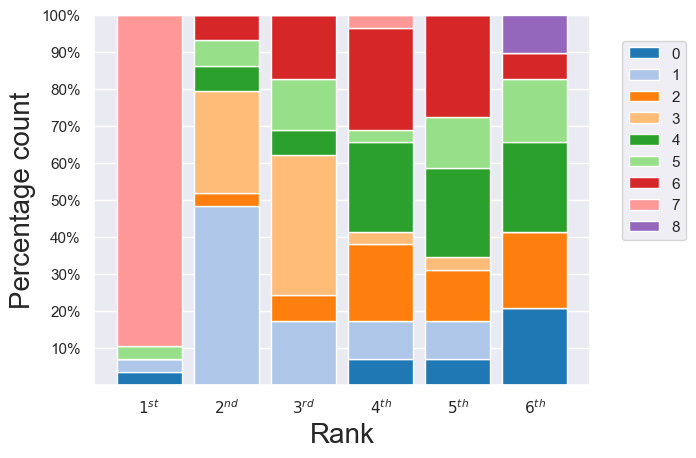

In [10]:
path=os.path.join(os.getcwd(),'images')
dim=X_tr.shape[1]
plt_importances_bars(imps,name,dim=dim,pwd=path)

#### Lympho

0          1          2          3          4          5   \
0    3.378378   2.027027   6.081081   2.027027   4.054054   4.729730   
1    6.756757  12.162162   2.027027   2.027027   6.756757   1.351351   
2    6.756757   6.081081   0.675676   1.351351   0.675676  11.486486   
3    7.432432  10.135135   2.702703   2.702703   2.702703   6.756757   
4   10.810811  10.135135   2.027027   1.351351   3.378378  10.135135   
5    9.459459  10.810811   0.675676   0.000000   6.081081  10.810811   
6    5.405405   9.459459   2.702703   2.702703   0.675676   5.405405   
7    8.108108   8.783784   5.405405   1.351351   3.378378   4.054054   
8    8.108108   8.783784   8.783784   2.027027   6.081081   2.027027   
9    6.081081   4.729730   6.756757   4.729730   5.405405   6.081081   
10   5.405405   3.378378   6.081081   2.027027   4.054054   6.081081   
11   3.378378   4.054054   6.081081   2.027027   6.756757   5.405405   
12   6.756757   1.351351  11.486486   4.054054   7.432432   3.378378   
13   4.054054   4.054054   6.081081   1.351351  10.135135   8.108108   
14   1.351351   2.027027   6.756757   4.054054  10.810811   5.405405   
15   2.702703   0.000000   7.432432   8.108108  10.810811   2.702703   
16   1.351351   2.027027   8.108108  25.675676   7.432432   3.378378   
17   2.702703   0.000000  10.135135  32.432432   3.378378   2.702703   

           6         7          8          9          10         11  \
0    4.054054  5.405405   4.729730   4.729730   2.027027   6.081081   
1    2.702703  6.081081   0.675676  10.135135   4.054054   4.729730   
2    0.000000  8.783784   2.027027   4.729730  12.162162   8.108108   
3    0.675676  4.729730   1.351351   2.702703   8.108108  10.135135   
4    0.000000  4.729730   0.675676   5.405405   6.081081   6.756757   
5    2.027027  6.081081   2.702703   5.405405   6.081081   5.405405   
6    4.729730  3.378378   6.756757   4.054054   4.729730   8.108108   
7    2.027027  6.756757   5.405405   3.378378   5.405405   8.108108   
8    3.378378  4.054054   4.054054   6.081081   7.432432   7.432432   
9    1.351351  3.378378   3.378378   6.756757   8.783784   7.432432   
10   2.702703  3.378378   8.783784   4.054054  10.135135   4.729730   
11   5.405405  7.432432   6.756757   4.054054   5.405405   8.108108   
12  10.135135  5.405405   8.108108   8.783784   6.756757   2.702703   
13   8.108108  8.108108  10.810811   7.432432   3.378378   1.351351   
14  12.837838  7.432432  10.810811   8.783784   4.054054   4.729730   
15  17.567568  7.432432  12.837838   3.378378   3.378378   4.054054   
16  19.594595  4.054054   6.756757   2.702703   2.027027   0.675676   
17   2.702703  3.378378   3.378378   7.432432   0.000000   1.351351   

           12         13        14         15         16         17  
0    9.459459   4.729730  4.729730   8.783784  12.162162  10.810811  
1   12.837838   2.027027  7.432432   8.108108   4.729730   5.405405  
2    6.756757   6.081081  6.756757   6.756757   5.405405   5.405405  
3    7.432432   8.783784  9.459459   8.108108   2.027027   4.054054  
4    4.729730   8.783784  8.783784   5.405405   5.405405   5.405405  
5    6.081081  10.135135  5.405405   5.405405   4.054054   3.378378  
6    4.054054   7.432432  4.729730  11.486486   6.756757   7.432432  
7    9.459459   4.729730  6.756757   8.108108   4.729730   4.054054  
8    5.405405  10.135135  4.054054   6.756757   2.702703   2.702703  
9    5.405405   8.783784  4.729730   4.054054   4.729730   7.432432  
10   3.378378   4.054054  5.405405   8.108108   6.756757  11.486486  
11   6.081081   6.756757  5.405405   7.432432   4.054054   5.405405  
12   4.729730   4.054054  4.054054   1.351351   3.378378   6.081081  
13   5.405405   3.378378  7.432432   4.054054   4.729730   2.027027  
14   4.729730   3.378378  6.081081   1.351351   4.054054   1.351351  
15   1.351351   2.702703  3.378378   3.378378   3.378378   5.405405  
16   1.351351   2.702703  3.378378   0.675676   6.081081   2.027027  
17   1.351351   1.351351  2.0270

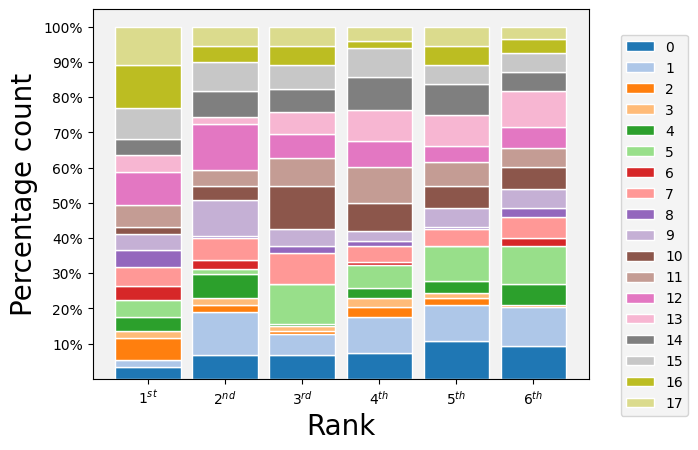

In [16]:
path=os.path.join(os.getcwd(),'images')
dim=X_tr.shape[1]
plt_importances_bars(imps,name,dim=dim,pwd=path)

#### Ionosphere

0         1          2          3          4          5          6   \
0   8.262108  1.424501   2.279202   2.564103   1.994302   5.698006   5.413105   
1   3.133903  1.709402   2.279202   2.849003   1.994302   6.267806   5.128205   
2   2.279202  3.133903   1.139601   0.854701   1.994302   3.418803   3.703704   
3   1.139601  3.418803   2.564103   1.424501   3.418803   2.849003   4.843305   
4   2.564103  2.849003   1.994302   2.279202   0.569801   3.418803   5.128205   
5   1.709402  3.988604   3.418803   2.564103   5.413105   1.709402   1.424501   
6   0.854701  2.564103   1.994302   1.709402   3.133903   2.564103   2.279202   
7   1.709402  2.564103   2.849003   1.424501   3.703704   3.418803   1.994302   
8   3.703704  3.703704   2.849003   2.564103   2.279202   3.133903   2.564103   
9   1.709402  5.128205   2.564103   1.139601   1.709402   2.564103   2.564103   
10  2.279202  4.273504   1.994302   2.279202   2.279202   1.709402   1.709402   
11  3.418803  2.849003   1.994302   0.854701   1.994302   1.709402   1.709402   
12  2.564103  1.994302   1.994302   2.564103   2.849003   1.709402   3.133903   
13  3.133903  2.849003   2.279202   1.709402   2.849003   1.424501   0.854701   
14  1.139601  1.994302   1.994302   2.849003   1.424501   0.854701   3.418803   
15  3.418803  2.849003   1.139601   1.994302   0.854701   2.564103   1.139601   
16  3.988604  2.564103   2.279202   1.994302   2.279202   2.279202   1.994302   
17  6.552707  5.982906   2.279202   1.709402   1.994302   1.139601   1.709402   
18  3.133903  2.564103   2.279202   1.994302   3.703704   1.709402   2.849003   
19  3.418803  8.547009   2.564103   3.133903   1.994302   1.709402   2.279202   
20  3.988604  5.413105   2.564103   2.564103   2.564103   1.994302   1.994302   
21  4.843305  3.133903   1.994302   3.418803   2.279202   3.418803   1.709402   
22  4.558405  5.128205   3.133903   1.424501   1.424501   1.424501   1.139601   
23  3.703704  3.133903   3.703704   1.709402   1.709402   1.424501   2.849003   
24  2.564103  2.279202   2.849003   1.424501   1.139601   1.709402   0.569801   
25  2.849003  2.564103   3.418803   2.279202   1.424501   2.564103   1.424501   
26  1.994302  1.709402   1.994302   2.279202   1.709402   2.279202   2.564103   
27  2.849003  2.849003   2.279202   2.279202   2.279202   2.564103  11.680912   
28  1.709402  2.279202   2.564103   2.564103   3.418803  15.954416   7.407407   
29  1.424501  1.139601   1.994302   2.849003  18.518519   6.837607   3.988604   
30  1.139601  1.709402   3.418803  19.943020   8.831909   3.988604   4.558405   
31  1.139601  1.424501  23.076923  12.250712   3.703704   1.139601   2.849003   
32  7.122507  0.284900   2.279202   4.558405   2.564103   2.849003   1.424501   

          7         8         9   ...        23        24        25        26  \
0   9.116809  3.418803  2.279202  ...  2.564103  3.133903  5.982906  0.569801   
1   5.698006  3.703704  3.133903  ...  5.698006  2.279202  3.418803  1.139601   
2   4.843305  4.558405  3.988604  ...  2.849003  3.418803  2.849003  0.854701   
3   8.262108  5.698006  3.418803  ...  0.854701  3.133903  4.558405  2.279202   
4   3.418803  1.709402  3.133903  ...  4.273504  3.133903  4.843305  2.279202   
5   3.703704  3.988604  1.139601  ...  1.709402  3.988604  3.703704  3.703704   
6   2.564103  3.418803  4.843305  ...  3.988604  3.418803  3.133903  2.279202   
7   2.849003  2.564103  0.854701  ...  3.703704  5.128205  3.988604  6.552707   
8   2.849003  2.849003  3.133903  ...  1.994302  6.552707  5.698006  2.279202   
9   4.273504  2.279202  5.413105  ...  3.988604  6.837607  3.418803  4.273504   
10  2.564103  2.279202  1.709402  ...  4.843305  4.273504  5.128205  5.982906   
11  2.564103  2.279202  3.133903  ...  4.558405  5.128205  3.133903  5.698006   
12  1.994302  1.709402  1.709402  ...  5.698006  5.413105  4.558405  7.122507   
13  3.418803  2.279202  1.994302  ...  3.418803  3.133903  2.279202  5.128205   
14  3.703704  3.133903  1.424501  ...  2

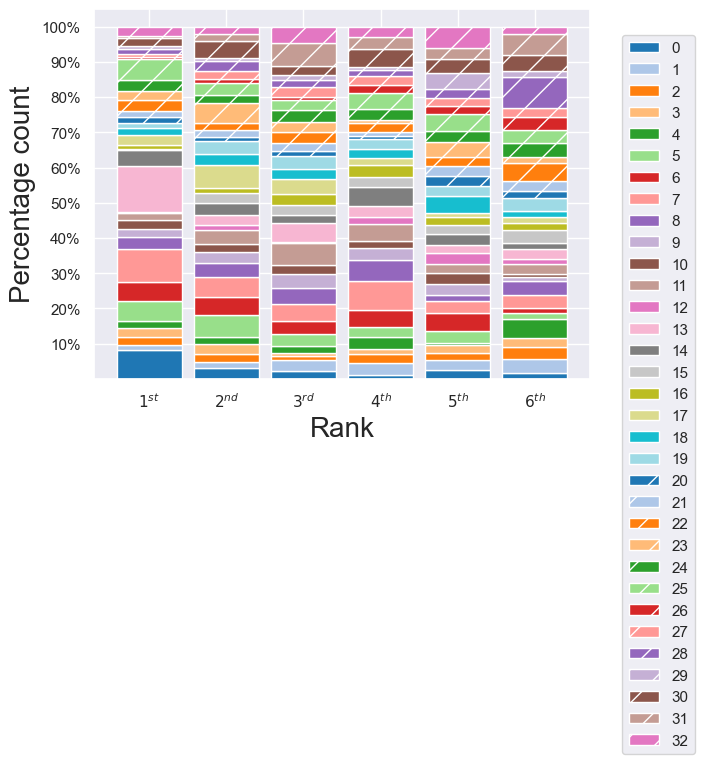

In [5]:
path=os.path.join(os.getcwd(),'images')
dim=X_tr.shape[1]
plt_importances_bars(imps,name,dim=dim,pwd=path)

#### Xaxis

0     1     2     3     4     5
0  100.0   0.0   0.0   0.0   0.0   0.0
1    0.0  40.0  42.0   1.0  14.0   3.0
2    0.0   9.0  37.0  12.0  31.0  11.0
3    0.0  12.0  10.0  22.0   9.0  47.0
4    0.0  21.0  10.0  30.0  11.0  28.0
5    0.0  18.0   1.0  35.0  35.0  11.0

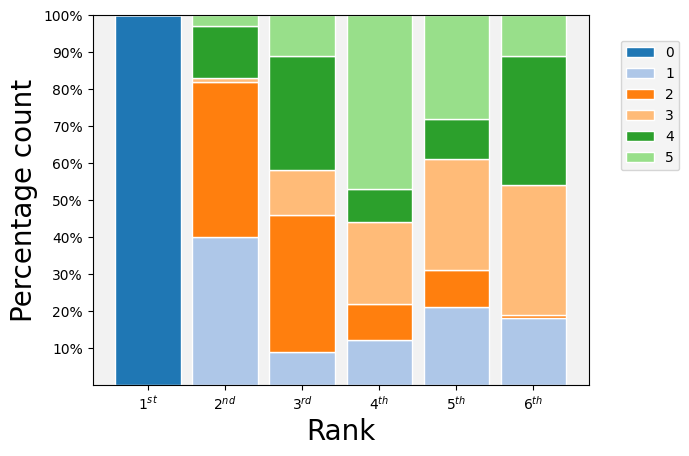

In [33]:
path=os.path.join(os.getcwd(),'images')
dim=X_tr.shape[1]
plt_importances_bars(imps,name,dim=dim,pwd=path)

### plt_feat_bar_plot

#### Glass

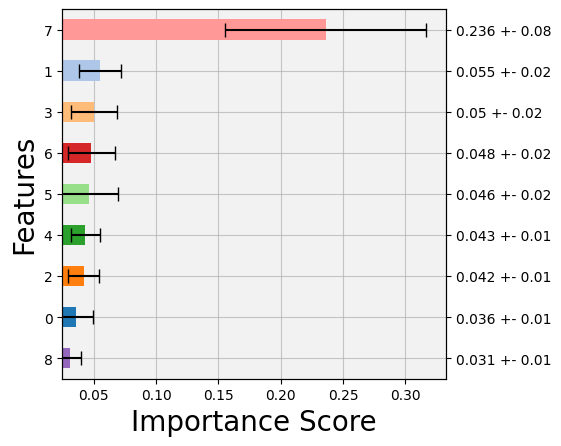

In [11]:
plt_feat_bar_plot(plt_data,name,pwd=path,save=True)

#### Lympho

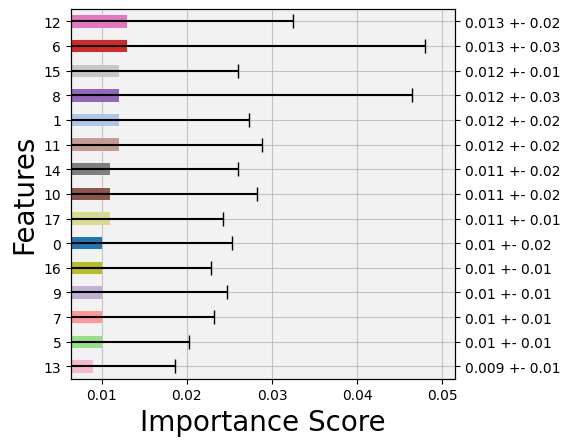

In [17]:
plt_feat_bar_plot(plt_data,name,pwd=path,save=True)

#### Ionosphere

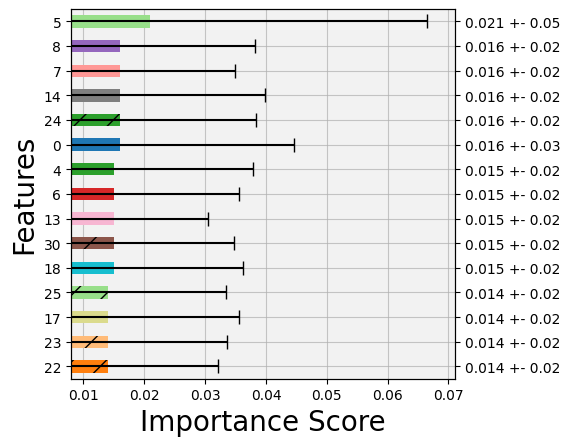

In [14]:
plt_feat_bar_plot(plt_data,name,pwd=path,save=True)

#### Xaxis

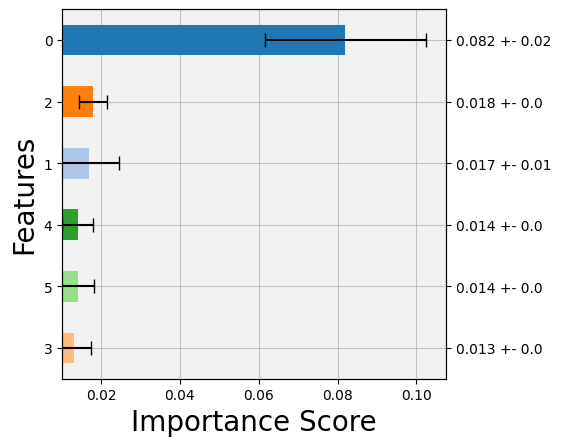

In [34]:
plt_feat_bar_plot(plt_data,name,pwd=path,save=True)

### plt_importance_map

#### Glass

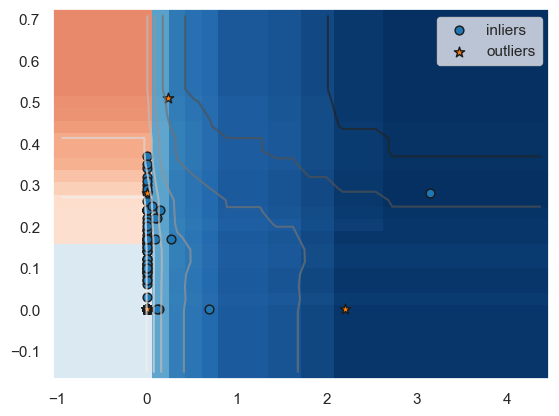

In [7]:
name='glass'
path=os.path.join(os.getcwd(),'images')
plot_importance_map(name,iforest_sklearn,X_tr,y_tr,30,pwd=path,save=True,feats_plot=(7,8))

#### Lympho

Handling the IndexError Exception...


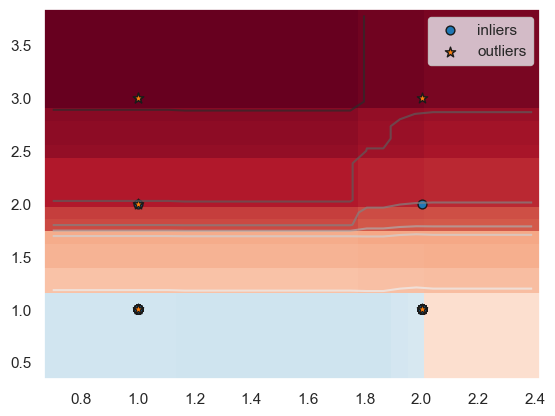

In [5]:
name='lympho'
path=os.path.join(os.getcwd(),'images')
plot_importance_map(name,iforest_sklearn,X_tr,y_tr,30,pwd=path,save=True,feats_plot=(7,8))

#### Ionosphere

Handling the IndexError Exception...


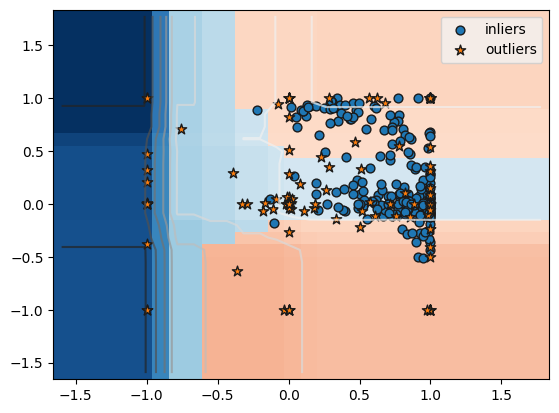

In [15]:
plot_importance_map(name,iforest_sklearn,X_tr,y_tr,30,pwd=path,save=True,feats_plot=(5,8))

#### Xaxis

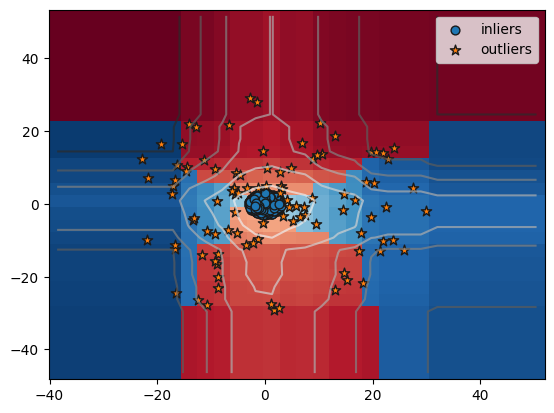

In [35]:
plot_importance_map(name,iforest_sklearn,X_tr,y_tr,30,pwd=path,save=True,feats_plot=(0,1))

### plt_complete_scoremap

This method takes a lot of time in particular with the datasets with a lot of features (like the ones contained in the folder data).

In [ ]:
plot_complete_scoremap(name,X_te.shape[1],iforest_sklearn,X_te,y_te)

## GFI

### compute_global_importances

#### Glass

In [6]:
name='glass'
pwd_imp_scores=os.path.join(os.getcwd(),'imp_scores')
pwd_plt_data=os.path.join(os.getcwd(),'plt_data')
iforest = IsolationForest(n_estimators= 100, max_samples=64, contamination=0.1, bootstrap=False)
global_imps,plt_data=compute_global_importances(iforest,X_tr,10,name,pwd_imp_scores,pwd_plt_data)

#### Lympho

In [ ]:
pwd_imp_scores=os.path.join(os.getcwd(),'imp_scores')
pwd_plt_data=os.path.join(os.getcwd(),'plt_data')
iforest = IsolationForest(n_estimators= 100, max_samples=64, contamination=0.1, bootstrap=False)
global_imps,plt_data=compute_global_importances(iforest,X_tr,10,name,pwd_imp_scores,pwd_plt_data)

### plt_importances_bars

#### Glass

0     1     2     3     4     5     6      7     8
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  100.0   0.0
1  20.0  10.0   0.0   0.0  50.0   0.0  20.0    0.0   0.0
2  10.0  60.0   0.0  10.0   0.0  10.0  10.0    0.0   0.0
3  30.0  20.0   0.0  10.0  10.0  10.0  20.0    0.0   0.0
4  20.0   0.0   0.0  30.0  10.0  20.0  20.0    0.0   0.0
5   0.0   0.0   0.0  10.0  20.0  40.0  20.0    0.0  10.0
6  20.0  10.0   0.0  40.0   0.0  20.0  10.0    0.0   0.0
7   0.0   0.0  50.0   0.0  10.0   0.0   0.0    0.0  40.0
8   0.0   0.0  50.0   0.0   0.0   0.0   0.0    0.0  50.0

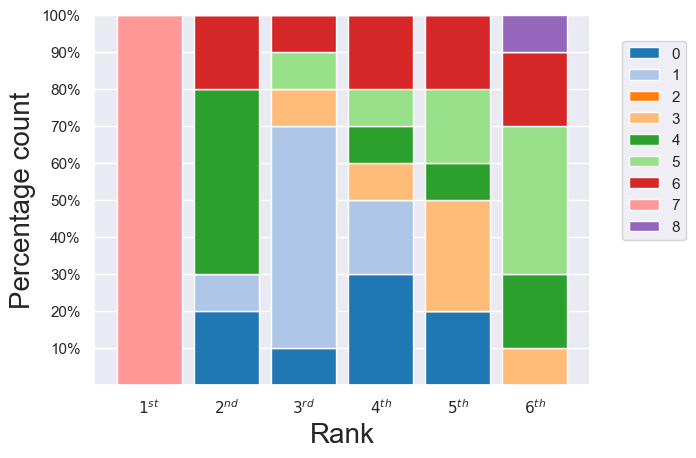

In [9]:
dim=X_tr.shape[1]
plt_importances_bars(global_imps,name,dim=dim,is_local=False)

#### Lympho

In [ ]:
dim=X_tr.shape[1]
plt_importances_bars(global_imps,name,dim=dim,is_local=False)

### plt_feat_bar_plot

#### Glass

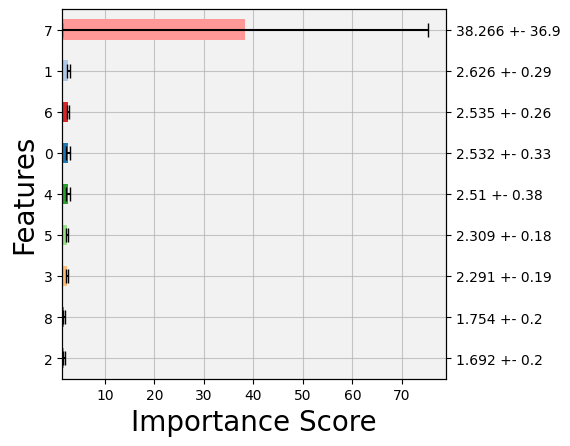

In [10]:
path=os.path.join(os.getcwd(),'images')
plt_feat_bar_plot(plt_data,name,pwd=path,is_local=False,save=True)

#### Lympho

In [ ]:
path=os.path.join(os.getcwd(),'images')
plt_feat_bar_plot(plt_data,name,pwd=path,is_local=False,save=True)

## Code to understand what to do in the pytest

## _get_iic

In [4]:
# start time
start = time.time()
# initialization
num_feat = X_tr.shape[1] 
estimators = iforest_sklearn.estimators_
cfi_outliers_ib = np.zeros(num_feat).astype('float')
cfi_inliers_ib = np.zeros(num_feat).astype('float')
counter_outliers_ib = np.zeros(num_feat).astype('int')
counter_inliers_ib = np.zeros(num_feat).astype('int')
in_bag_samples = iforest_sklearn.estimators_samples_

In [5]:
# for every iTree in the _sklearn
for k, estimator in enumerate(estimators):
    # get in-bag samples indices
    in_bag_sample = list(in_bag_samples[k])
    # get in-bag samples (predicted inliers and predicted outliers)
    X_ib = X_tr[in_bag_sample,:]
    as_ib = decision_function_single_tree(iforest_sklearn, k, X_ib)
    X_outliers_ib = X_ib[np.where(as_ib < 0)]
    X_inliers_ib = X_ib[np.where(as_ib > 0)]
    if X_inliers_ib.shape[0] == 0 or X_outliers_ib.shape[0] == 0:
        continue
    # compute relevant quantities
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    # compute node depths
    stack = [(0, -1)]  
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1
        # if we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

In [6]:
from interpretability_module import _get_iic
lambda_outliers_ib = _get_iic(estimator, X_outliers_ib, is_leaves, adjust_iic=True)

In [8]:
lambda_outliers_ib.shape[0]

29

In [31]:
lambda_outliers_ib.shape, X_outliers_ib.shape

((29,), (10, 9))

In [46]:
np.random.seed(0)
X = np.random.randn(100, 10)
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, random_state=0)
iforest.fit(X)
is_leaves=np.random.choice([True, False], size=X.shape[0])
#adjust_iic=np.random.choice([True, False], size=1)
lambda_outliers_ib_false = _get_iic(iforest.estimators_[1], X, is_leaves, adjust_iic=False)
lambda_outliers_ib_true = _get_iic(iforest.estimators_[1], X, is_leaves, adjust_iic=True)
lambda_outliers_ib_false

array([-1.        , -1.        ,  0.66666667,  0.66666667, -1.        ,
       -1.        , -1.        , -1.        ,  0.83333333, -1.        ,
        0.8       , -1.        ,  0.5       ,  0.5       , -1.        ,
       -1.        ,  0.5       , -1.        , -1.        ,  0.85714286,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        ,  0.5       , -1.        , -1.        , -1.        ,
       -1.        ,  0.75      , -1.        ,  0.66666667, -1.        ,
       -1.        , -1.        , -1.        , -1.        ,  0.98734177,
       -1.        ,  0.94871795,  0.60810811, -1.        ,  0.2       ,
       -1.        ,  0.75555556, -1.        ,  0.09090909,  0.75      ,
        0.66666667,  0.5       , -1.        , -1.        , -1.        ])

In [47]:
lambda_outliers_ib_true

array([-1.        , -1.        ,  0.66666667,  0.66666667, -1.        ,
       -1.        , -1.        , -1.        ,  1.        , -1.        ,
        1.        , -1.        ,  0.5       ,  0.5       , -1.        ,
       -1.        ,  0.5       , -1.        , -1.        ,  1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        ,  0.5       , -1.        , -1.        , -1.        ,
       -1.        ,  1.        , -1.        ,  0.66666667, -1.        ,
       -1.        , -1.        , -1.        , -1.        ,  1.        ,
       -1.        ,  0.96052632,  0.61111111, -1.        , -0.5       ,
       -1.        ,  0.76190476, -1.        , -0.125     ,  1.        ,
        0.66666667,  0.5       , -1.        , -1.        , -1.        ])

In [51]:
lambda_outliers_ib_false >= 0.7

array([False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False])

## local_diffi

In [19]:
# create a random dataset
np.random.seed(0)
# local_diffi works on a single sample
X = np.random.randn(100,10)
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, max_samples=64 ,random_state=0)
iforest.fit(X)
#Select a single sample from X at random
x=X[np.random.randint(0,X.shape[0]),:]

In [22]:
fi,time=local_diffi(iforest,x)

In [23]:
time

0.008695840835571289

In [20]:
# start time
start = time.time()
# initialization 
estimators = iforest.estimators_
cfi = np.zeros(len(x)).astype('float')
counter = np.zeros(len(x)).astype('int')
max_depth = int(np.ceil(np.log2(iforest.max_samples)))

## local_diffi_batch

In [24]:
# create a random dataset
np.random.seed(0)
# local_diffi works on a single sample
X = np.random.randn(100,10)
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, max_samples=64 ,random_state=0)
iforest.fit(X)

IsolationForest(max_samples=64, n_estimators=10, random_state=0)

In [25]:
fi_ib,ord_idx,exec_time=local_diffi_batch(iforest, X)
fi_ib.shape,X.shape

((100, 10), (100, 10))

In [26]:
exec_time

[0.008002281188964844,
 0.005988597869873047,
 0.008008956909179688,
 0.006990194320678711,
 0.0019989013671875,
 0.005002021789550781,
 0.009003162384033203,
 0.003994941711425781,
 0.0020029544830322266,
 0.008997201919555664,
 0.005005359649658203,
 0.004996538162231445,
 0.008005142211914062,
 0.002997875213623047,
 0.0059947967529296875,
 0.00901341438293457,
 0.005988597869873047,
 0.008002042770385742,
 0.005002498626708984,
 0.04299569129943848,
 0.004998922348022461,
 0.004000425338745117,
 0.0070002079010009766,
 0.0049991607666015625,
 0.005999088287353516,
 0.006005048751831055,
 0.0050067901611328125,
 0.007990598678588867,
 0.012999773025512695,
 0.0070002079010009766,
 0.0030012130737304688,
 0.006998777389526367,
 0.0060007572174072266,
 0.0070002079010009766,
 0.005004167556762695,
 0.008997440338134766,
 0.0050008296966552734,
 0.008994102478027344,
 0.005001544952392578,
 0.005999565124511719,
 0.005003213882446289,
 0.0029997825622558594,
 0.0049991607666015625,
 0.

## compute_local_importances

In [3]:
# create a random dataset
np.random.seed(0)
# local_diffi works on a single sample
X = np.random.randn(100,10)
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, max_samples=64 ,random_state=0)
iforest.fit(X)
imp_score_path=os.path.join(os.getcwd(),'imp_scores')
plt_data_path=os.path.join(os.getcwd(),'plt_data')
name='test'
imps,plt_data,path_fi,path_plt_data=compute_local_importances(iforest,X,name,imp_score_path,plt_data_path)

In [6]:
pickle.load(open(path_plt_data,'rb'))

{'Importances': array([0.00302778, 0.00578659, 0.0061828 , 0.00781217, 0.00918624,
        0.00938135, 0.00954048, 0.00968045, 0.01192269, 0.01221124]),
 'feat_order': array([3, 0, 7, 1, 6, 9, 8, 2, 4, 5], dtype=int64),
 'std': array([0.0123734 , 0.01245985, 0.01632168, 0.03286729, 0.0154525 ,
        0.01837945, 0.02232898, 0.02532521, 0.01537595, 0.03801821])}

In [9]:
plt_data_keys=list(plt_data.keys())
imp,feat_ord,std=plt_data[plt_data_keys[0]],plt_data[plt_data_keys[1]],plt_data[plt_data_keys[2]]

In [9]:
imp_score_path=os.path.join(os.getcwd(),'imp_scores')
plt_data_path=os.path.join(os.getcwd(),'plt_data')
name='test_global'

In [10]:
nruns=np.random.randint(1,10)
fi,plt_data,path_fi,path_plt_data=compute_global_importances(iforest,X,nruns,name,pwd_imp_score=imp_score_path,pwd_plt_data=plt_data_path)

In [12]:
plt_data_keys=list(plt_data.keys())
imp,feat_ord,std=plt_data[plt_data_keys[0]],plt_data[plt_data_keys[1]],plt_data[plt_data_keys[2]]

In [15]:
std.shape,X.shape

((10,), (100, 10))

## plt_importances_bars

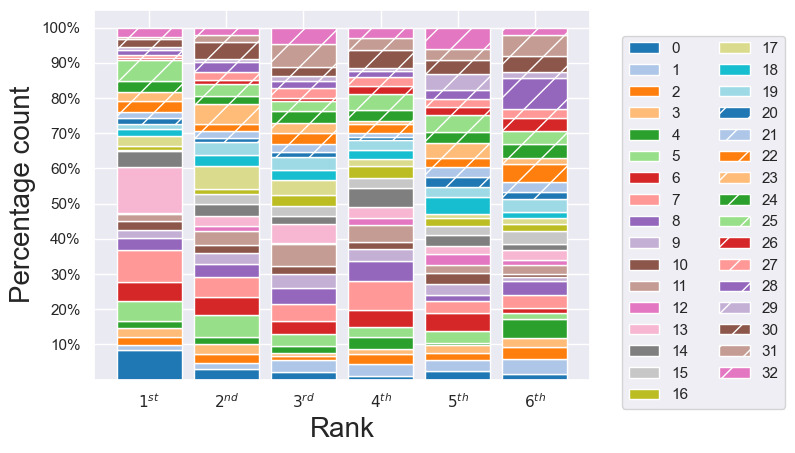

In [3]:
import os
pwd=os.path.join(os.getcwd(),'images')
imps_path=os.path.join(os.getcwd(),'imp_scores','imp_score_LFI_ionosphere.pkl')
fig,ax,bars=plt_importances_bars(imps_path,name='bar_plot_test',pwd=pwd)
#fig,ax,bars=plt_importances_bars(imps_path,name='bar_plot_test',pwd=pwd)
#plt.show()

In [4]:
with open(imps_path, 'rb') as f:
        importances = pickle.load(f)
type(importances)

numpy.ndarray

In [5]:
importances.shape[1]

9

In [13]:
ax.get_xlabel()

'Rank'

In [14]:
ax.get_ylabel()

'Percentage count'

In [11]:
x_tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
y_tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]

In [17]:
x_tick_labels

['$1^{st}$', '$2^{nd}$', '$3^{rd}$', '$4^{th}$', '$5^{th}$', '$6^{th}$']

In [19]:
y_tick_labels

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']

In [21]:
legend = ax.legend()
title = legend.get_title().get_text()

''

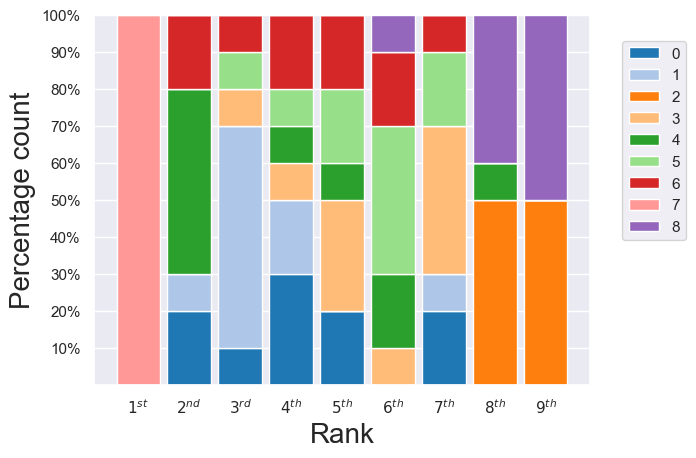

In [16]:
fig1,ax1,bars1=plt_importances_bars(imps,name='bar_plot_test',dim=imps.shape[1],pwd=pwd,f=9)
plt.show()

In [22]:
x_tick_labels1 = [tick.get_text() for tick in ax1.get_xticklabels()]
y_tick_labels1 = [tick.get_text() for tick in ax1.get_yticklabels()]

In [24]:
y_tick_labels1

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']

In [30]:
bars.shape

(9, 9)

In [4]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import numpy as np

# Save figure1 as an image
canvas = FigureCanvas(fig)
canvas.draw()
image1 = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

In [4]:
! pip install pdf2image


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\lemeda98\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
from pdf2image import convert_from_path
from PIL import Image

# Specify the path to the PDF file
pdf_file = os.path.join(os.getcwd(),'images','GFI_glass_synt.pdf')

# Convert the PDF to a list of PIL Image objects
images = convert_from_path(pdf_file)

# Save each image as a PNG file
for i, img in enumerate(images):
    img.save(f'GFI_glass_synt{i}.png', 'PNG')

In [14]:
type(images[0])

PIL.PpmImagePlugin.PpmImageFile

In [21]:
! pip install opencv-python


   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.1 MB 4.3 MB/s eta 0:00:09
   ---------------------------------------- 0.4/38.1 MB 5.0 MB/s eta 0:00:08
    --------------------------------------- 0.7/38.1 MB 5.4 MB/s eta 0:00:07
    --------------------------------------- 0.9/38.1 MB 5.8 MB/s eta 0:00:07
   - -------------------------------------- 1.3/38.1 MB 5.0 MB/s eta 0:00:08
   - -------------------------------------- 1.5/38.1 MB 5.4 MB/s eta 0:00:07
   - -------------------------------------- 1.7/38.1 MB 5.5 MB/s eta 0:00:07
   -- ------------------------------------- 2.0/38.1 MB 5.5 MB/s eta 0:00:07
   -- ------------------------------------- 2.2/38.1 MB 5.3 MB/s eta 0:00:07
   -- ------------------------------------- 2.4/38.1 MB 5.2 MB/s eta 0:00:07
   -- ------------------------------------- 2.6/38.1 MB 5.2 MB/s eta 0:00:07
   -- ------------------------------------- 2.7/38.1 MB 5.1 MB/s eta 0:00:07
   ---

In [24]:
import cv2
import numpy as np

# Load the images
image1 = cv2.imread(os.path.join(os.getcwd(),'images','GFI_glass_synt_test.png'))
image2 = cv2.imread(os.path.join(os.getcwd(),'images','GFI_glass_synt_expected.png'))

# Resize the larger image to match the shape of the smaller image
if image1.shape[0] * image1.shape[1] < image2.shape[0] * image2.shape[1]:
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
else:
    image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

# Convert images to NumPy arrays for comparison
array1 = np.array(image1)
array2 = np.array(image2)

# Compare the images for visual similarity (e.g., using mean squared error)
mse = np.mean((array1 - array2) ** 2)

# Define a threshold for similarity
threshold = 0.1  # Adjust as needed

if mse < threshold:
    print("Figures are visually similar.")
else:
    print("Figures are not visually similar.")


Figures are not visually similar.


## plt_feat_bar_plot

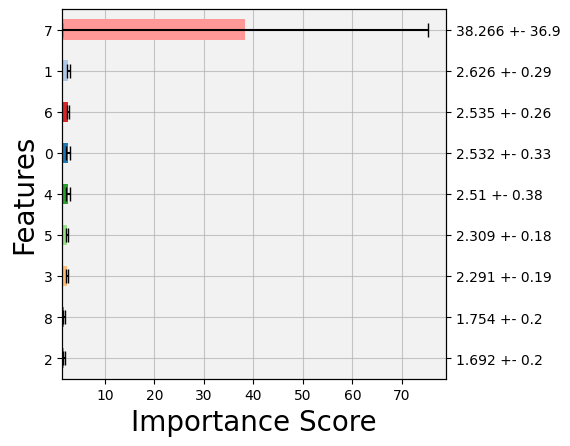

In [3]:
plt_data_global_path=os.path.join(os.getcwd(),'plt_data','plt_data_GFI_glass.pkl')
plt_data_local_path=os.path.join(os.getcwd(),'plt_data','plt_data_LFI_glass.pkl')

name_global='test_GFI_Glass'
name_local='test_LFI_Glass'

plot_path=os.path.join(os.getcwd(),'images')

ax1,ax2=plt_feat_bar_plot(plt_data_global_path,name_global,pwd=plot_path,is_local=False)
plt.show()

In [12]:
x_tick_labels = [tick.get_text() for tick in ax1.get_xticklabels()]
y_tick_labels = [tick.get_text() for tick in ax1.get_yticklabels()]
y_tick_labels

['2', '8', '3', '5', '4', '0', '6', '1', '7']

In [14]:
y_tick_labels2 = [tick.get_text() for tick in ax2.get_yticklabels()]
len(y_tick_labels2)

9

In [24]:
yticks=np.array(y_tick_labels).astype('float')
yticks>5

array([False,  True, False, False, False, False,  True, False,  True])

In [26]:
np.all(np.array(y_tick_labels).astype('float')>=np.array(y_tick_labels).astype('float'))

False

## plot_importance_map

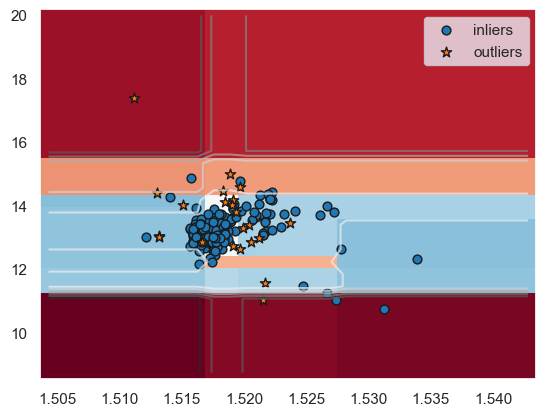

In [3]:
name='Glass'
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, max_samples=64, random_state=0)
iforest.fit(X_tr)
plot_path=os.path.join(os.getcwd(),'tests','test_plots')

_,_=plot_importance_map(name,iforest,X_tr,y_tr,30,pwd=plot_path)


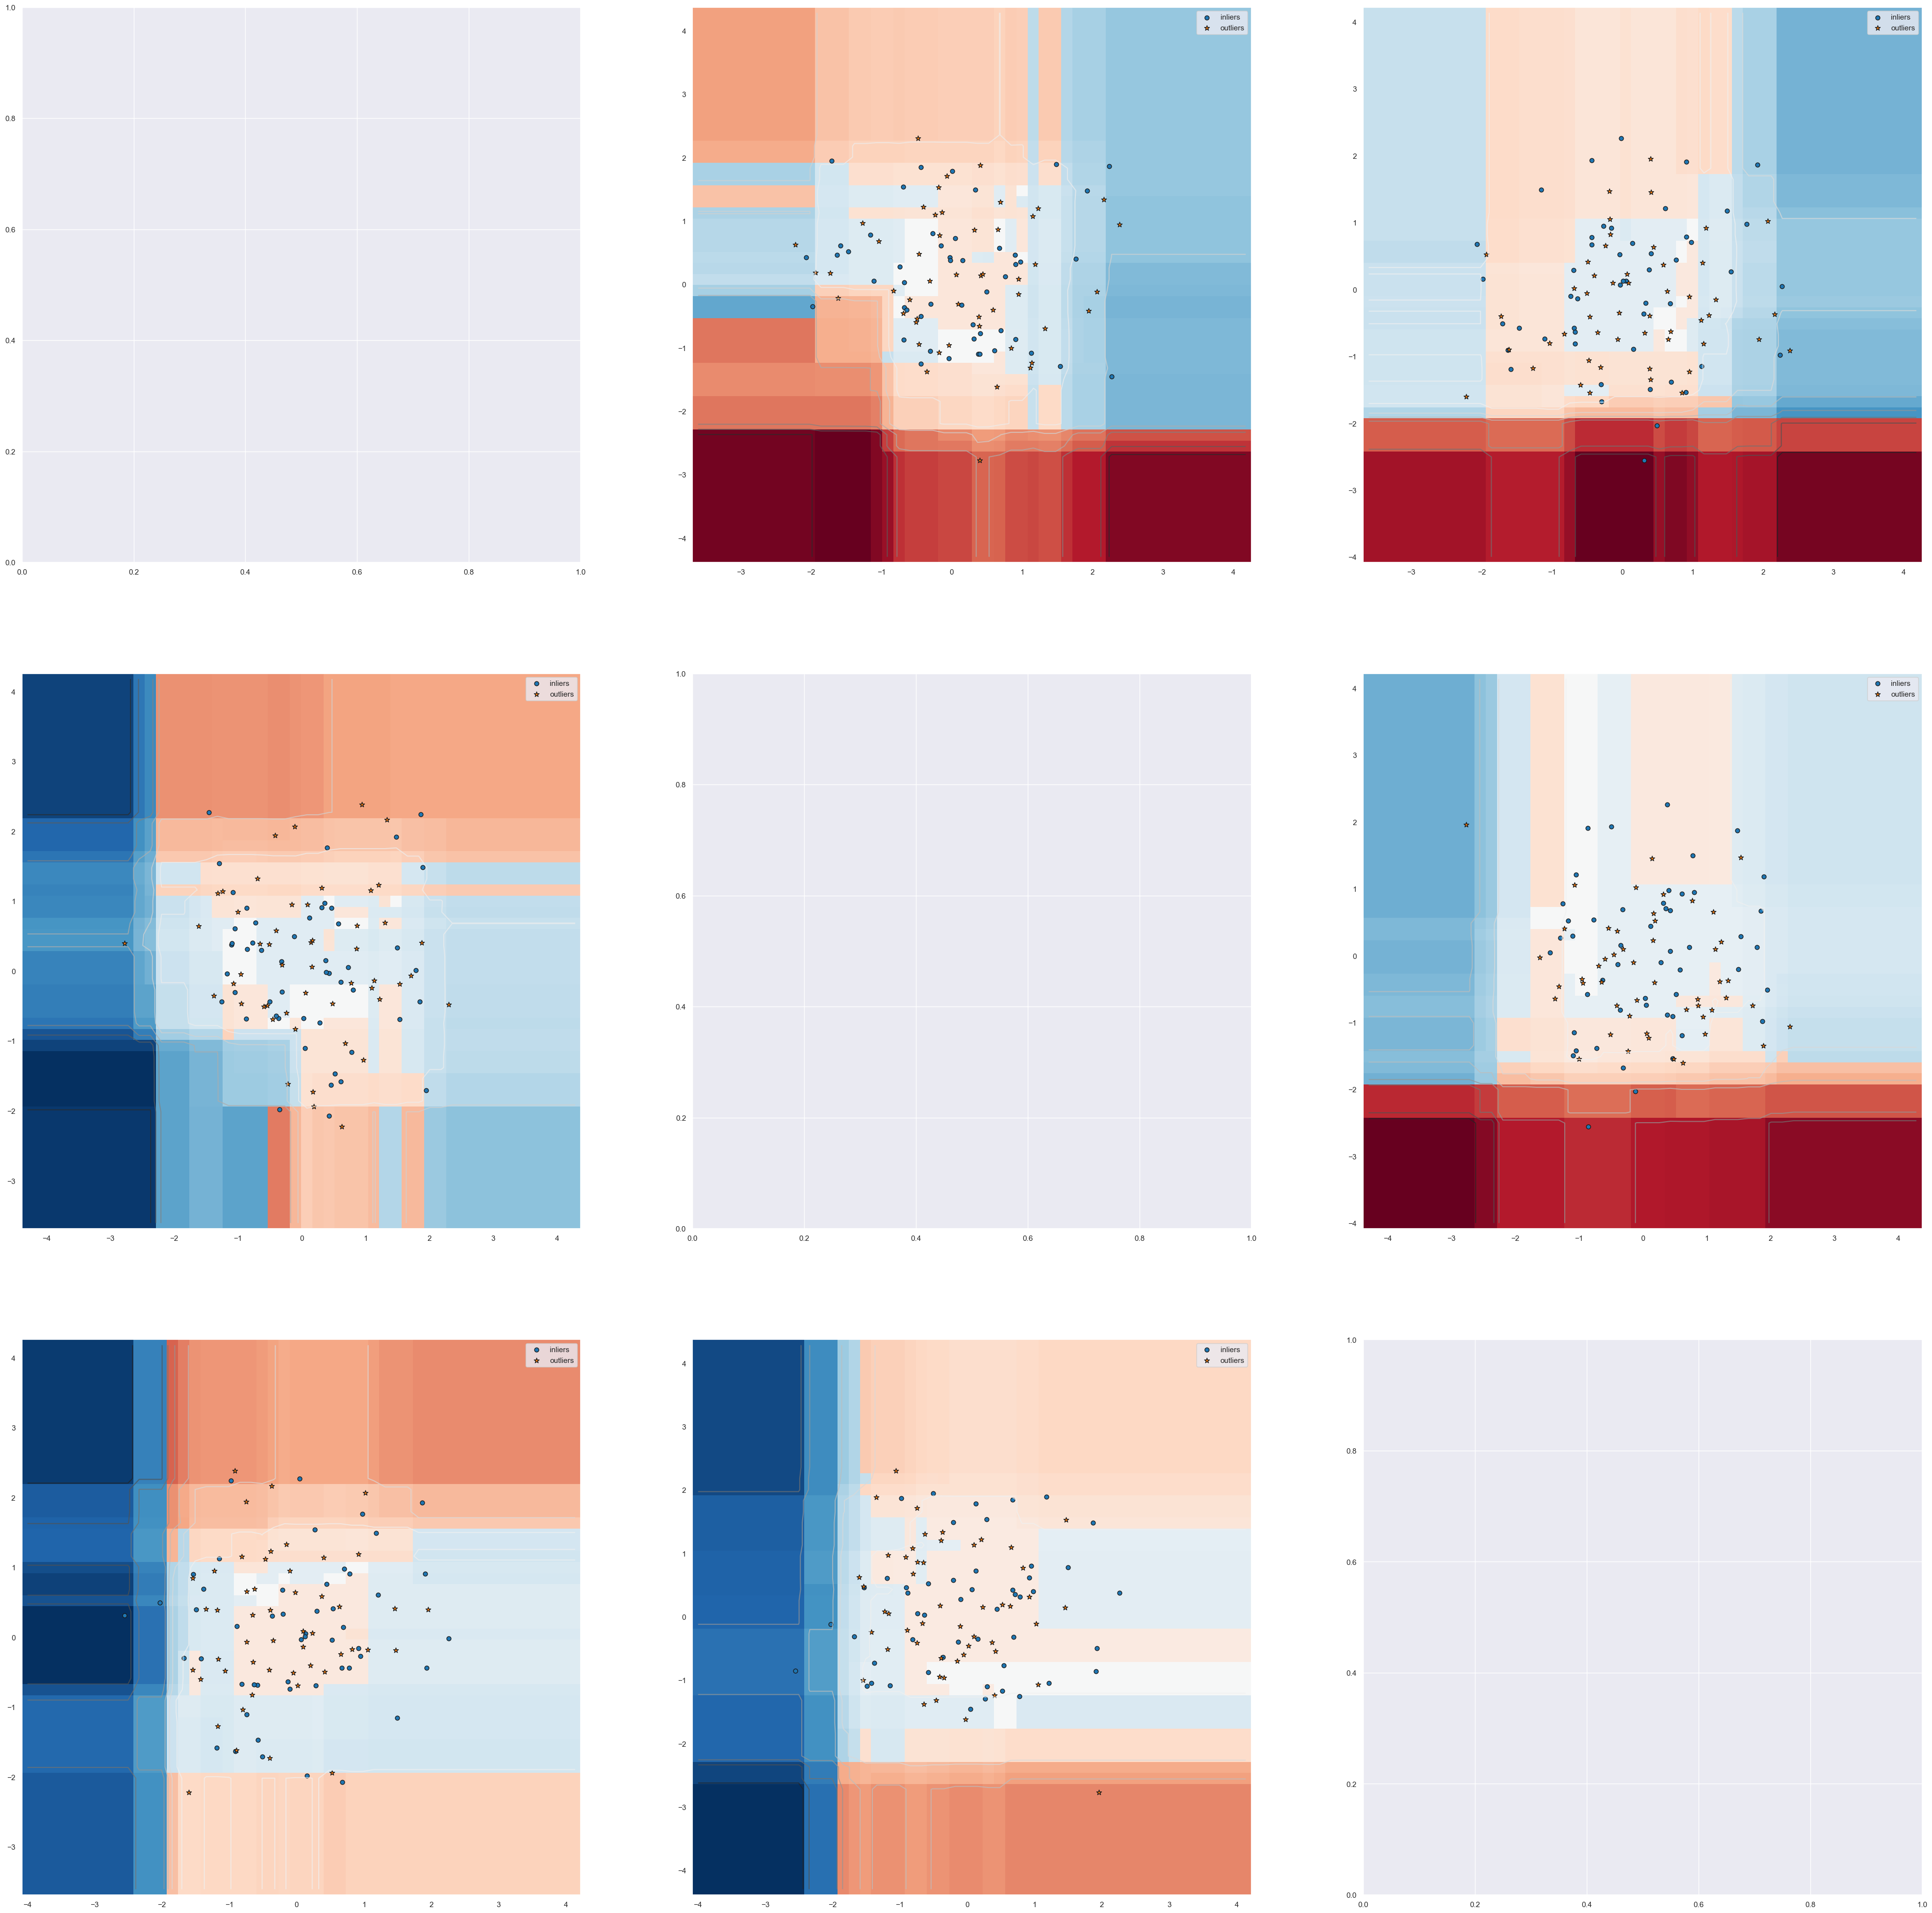

In [4]:
np.random.seed(0)
X = np.random.randn(100, 3)
#Assign at random the anomalous/not anomaoous labels
#Create a random array of 0 and 1 of shape=(100,)
y=np.random.randint(0,2,size=100)
name='test_complete'
# create an isolation forest model
iforest = IsolationForest(n_estimators=10, max_samples=64, random_state=0)
iforest.fit(X)
plot_path=os.path.join(os.getcwd(),'tests','test_plots')

fig,ax=plot_complete_scoremap(name,X.shape[1],iforest,X,y,pwd=plot_path)